In [1]:
import math
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from ecell4.core import *
from ecell4.util import *
from ecell4 import *
#from ecell4.gillespie import GillespieWorld as world_type, GillespieSimulator as simulator_type
#from ecell4.ode import odeWorld as world_type, OdeSimulator as simulator_type

In [2]:
@species_attributes
def attrgen(radius, D):
    K | {"radius": radius, "D": D}
    Kp | {"radius": radius, "D": D}
    Kpp | {"radius": radius, "D": D}
    KK | {"radius": radius, "D": D}
    PP | {"radius": radius, "D": D}
    K_KK | {"radius": radius, "D": D}
    Kp_KK | {"radius": radius, "D": D}
    Kpp_PP | {"radius": radius, "D": D}
    Kp_PP | {"radius": radius, "D": D}

@reaction_rules
def rulegen(kon1, koff1, kcat1, kon2, koff2, kcat2):
#rulegen(ka1, kd2, kcat1, ka2, kd2, kcat2)    
    (K + KK == K_KK | (kon1, koff1)
        > Kp + KK | kcat1
        == Kp_KK | (kon2, koff2)
        > Kpp + KK | kcat2)

    (Kpp + PP == Kpp_PP | (kon1, koff1)
        > Kp + PP | kcat1
        == Kp_PP | (kon2, koff2)
        > K + PP | kcat2)


In [3]:
ka1, kd1, kcat1 = 0.04483455086786913, 1.35, 1.5
ka2, kd2, kcat2 = 0.09299017957780264, 1.73, 15.0

In [4]:
def run(ratio,m):
    w = ode.ODEWorld(Real3(1,1,1))#world_type(Real3(1, 1, 1))
    w.bind_to(m)
    w.add_molecules(Species("K"), NKT)
    npp = int(60./(ratio+1))
    nkk = 60-npp
    w.add_molecules(Species("KK"), nkk)
    w.add_molecules(Species("PP"), npp)
    sim = ode.ODESimulator(m,w)#simulator_type(m, w)
    obs = FixedIntervalNumberObserver(1.0, ["KK","Kpp","PP"])
    sim.run(dur, [obs])
    data = np.array(obs.data()).T
    NKK = data[1]
    NKpp = data[2]
    NP = data[3]
    tt = data[0]
    return tt,NKK,NKpp,NP

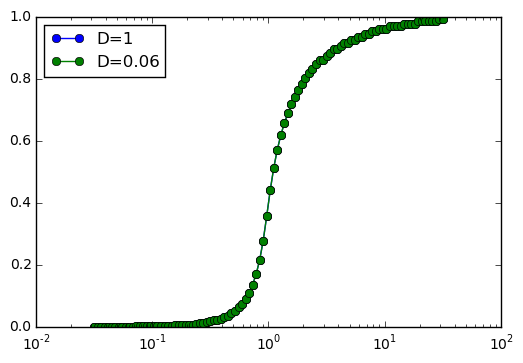

In [14]:
radius = 0.0025
ratios = np.logspace(-1.5,1.5,100)
NKT = 120
dur = 200
Ds = [1,0.06]

for D in Ds:    
    m = NetworkModel()
    for i, sp in enumerate(attrgen(str(radius), str(D))):
        #print(i, sp.serial(), sp.get_attribute("radius"), sp.get_attribute("D"))
        m.add_species_attribute(sp)
    def kon(k):
        kD = 4*3.14*2*radius*2*D
        return k*kD/(k+kD)
    def koff(kd,ka):
        return kon(ka)*kd/ka
    rul = rulegen(ka1, kd2, kcat1, ka2, kd2, kcat2)
    #rul = rulegen(kon(ka1), koff(kd2,ka1), kcat1, kon(ka2), koff(kd2,ka2), kcat2)
    for i, rr in enumerate(rul):
        reactants, products, k = rr.reactants(), rr.products(), rr.k()
        #print(i, rr.as_string())
        m.add_reaction_rule(rr)
    xx = []
    yy = []    
    for ratio in ratios:
        tt,NKK,NKpp,NP = run(ratio,m)
        xx.append( ratio)#np.mean(NKK[int(dur*0.5):])/np.mean(NP[int(dur*0.5):]))
        yy.append(np.mean(NKpp[int(dur*0.5):])/NKT)
    plt.semilogx(xx,yy,'-o',label='D='+str(D))
plt.ylim(0,1)
plt.xlim(0.01,100)
plt.legend(loc='best')


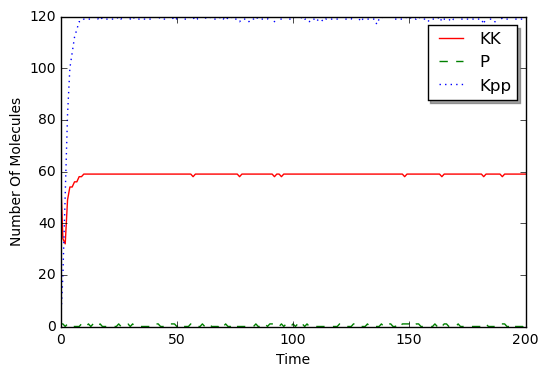

In [27]:
plt.plot(tt, NKK, "r-", label="KK")
plt.plot(tt,NP , "g--", label="P")
plt.plot(tt, NKpp, "b:", label="Kpp")
plt.xlabel("Time")
plt.ylabel("Number Of Molecules")
#plt.xlim(data[0][0], data[0][-1])
plt.legend(loc="best", shadow=True)
plt.show()

In [7]:
print len(yy)
print len(ratios)

50
50
